In [1]:
import math
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib

from PIL import Image

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
all_x = joblib.load('dataset-images.joblib')
all_y = joblib.load('dataset-labels.joblib')

all_x = ((all_x / 255) - 0.5) / 0.5
all_x = all_x.transpose((0, 3, 1, 2))

In [3]:
# Shuffle and split into training and validation sets
N = all_x.shape[0]
inds = np.arange(N)
np.random.shuffle(inds)

x_train = all_x[inds[:(math.floor(0.75 * N))], ...]
y_train = all_y[inds[:(math.floor(0.75 * N))], ...]
x_test = all_x[inds[(math.floor(0.75 * N)):], ...]
y_test = all_y[inds[(math.floor(0.75 * N)):], ...]
x_train = torch.tensor(x_train, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
x_test = torch.tensor(x_test, dtype=torch.float, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)


In [4]:
train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)
dataloaders = {
    'train': DataLoader(train_ds, batch_size=200),
    'val': DataLoader(test_ds, batch_size=400)
}

In [5]:
dataset_sizes = {
    'train': x_train.shape[0],
    'val': x_test.shape[0]
}

In [6]:
class_names = ['0', 'J', 'R', 'G', 'B', 'Y', 'P']

In [7]:
class PuyoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2880, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 7),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 30)
        x = self.fc(x)
        return x

In [8]:
# lr = 0.001
lr = 0.005
# lr = 0.0005
model = PuyoClassifier()
model.cuda(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track loss and accuracy over epochs
    hist = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        hist_row = [epoch]
        end_early = False

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # # Run on CUDA
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (epoch_acc < 0.01):
                print('Preds', preds, preds.dtype)
                print('Labels', labels.data, labels.data.dtype)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            hist_row.append(epoch_loss)
            hist_row.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if epoch_acc > 0.994:
                    end_early = True

        hist.loc[epoch] = hist_row
        print()
        if end_early:
            break
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [9]:
trained_model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, 1000)

Epoch 0/999
----------
train Loss: 0.6435 Acc: 0.6894
val Loss: 0.6294 Acc: 0.6866

Epoch 1/999
----------
train Loss: 0.6043 Acc: 0.6975
val Loss: 0.6258 Acc: 0.6922

Epoch 2/999
----------
train Loss: 0.6042 Acc: 0.6972
val Loss: 0.6119 Acc: 0.6914

Epoch 3/999
----------
train Loss: 0.4509 Acc: 0.7791
val Loss: 0.3356 Acc: 0.8386

Epoch 4/999
----------
train Loss: 0.2935 Acc: 0.8529
val Loss: 0.3025 Acc: 0.8502

Epoch 5/999
----------
train Loss: 0.2949 Acc: 0.8524
val Loss: 0.3080 Acc: 0.8460

Epoch 6/999
----------
train Loss: 0.2967 Acc: 0.8521
val Loss: 0.2923 Acc: 0.8521

Epoch 7/999
----------
train Loss: 0.1936 Acc: 0.9030
val Loss: 0.0385 Acc: 0.9889

Epoch 8/999
----------
train Loss: 0.0185 Acc: 0.9943
val Loss: 0.0246 Acc: 0.9933

Epoch 9/999
----------
train Loss: 0.0126 Acc: 0.9960
val Loss: 0.0041 Acc: 0.9988

Training complete in 2m 8s
Best val Acc: 0.998775


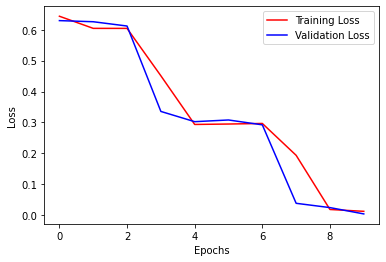

In [10]:
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'train_loss'], 'r', label='Training Loss')
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'val_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

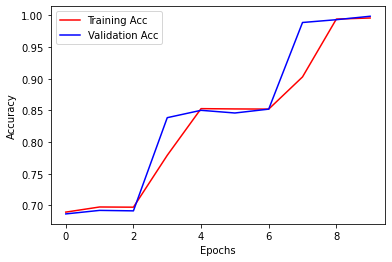

In [11]:
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'train_acc'], 'r', label='Training Acc')
plt.plot(history.loc[:, 'epoch'], history.loc[:, 'val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), 'puyo-classifier-aug10b.pt')

In [19]:
import torch.onnx
model.train(False)
dummy = torch.randn(200, 3, 30, 32, device=device)
torch_out = model(dummy)
torch.onnx.export(model, dummy, "puyo-mlp-gpu.onnx", export_params=True, opset_version=10, do_constant_folding=True, input_names=["input"], output_names=["output"], dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

In [21]:
import torch.onnx
cpu_model = model.to('cpu')
cpu_model.train(False)
dummy = torch.randn(200, 3, 30, 32)
torch_out = cpu_model(dummy)
torch.onnx.export(cpu_model, dummy, "puyo-mlp-cpu.onnx", export_params=True, opset_version=10, do_constant_folding=True, input_names=["input"], output_names=["output"], dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})